In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

Dados baixados do [site de microdados da Anac](https://sistemas.anac.gov.br/sas/downloads/view/frmDownload)

(Data downloaded [Anac's microdata website](https://sistemas.anac.gov.br/sas/downloads/view/frmDownload))

In [2]:
df_all = pd.read_csv('dados/2012-2017_1.CSV', sep=';', decimal=',')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25986362 entries, 0 to 25986361
Data columns (total 7 columns):
ANO         int64
MES         int64
EMPRESA     object
ORIGEM      object
DESTINO     object
TARIFA      float64
ASSENTOS    int64
dtypes: float64(1), int64(3), object(3)
memory usage: 1.4+ GB


In [3]:
df_all['DTTM'] = pd.to_datetime(dict(year=df_all['ANO'], month=df_all['MES'], day=15))
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25986362 entries, 0 to 25986361
Data columns (total 8 columns):
ANO         int64
MES         int64
EMPRESA     object
ORIGEM      object
DESTINO     object
TARIFA      float64
ASSENTOS    int64
DTTM        datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 1.5+ GB


Vamos restringir a análise às tarifas populares (que seriam, em tese, as beneficiadas pela cobrança de bagagem à parte) emitidas pela Gol. Os dados não discriminam qual seria a tarifa popular, mas parece razoável considerar que ela seja a tarifa com maior número de assentos em cada trecho.

Let's restrict the analysis to popular tickets (the ones that should have been benefited from the separate luggage charging) issued by Gol airline. The data doesn't discriminate which tickets are the "popular" ones, but it seems reasonable to assume that the ticket with the greatest number of seats are the ones we're looking for.

In [4]:
df_gol = df_all[df_all['EMPRESA'] == 'GLO']
df_grouped = df_gol.groupby(['DTTM', 'ORIGEM', 'DESTINO'])
assentos_max = df_grouped['ASSENTOS'].max()
df_gol_popular = df_gol[df_gol['ASSENTOS'] == df_grouped['ASSENTOS'].transform('max')]

In [5]:
df_gol_popular.head()

,ANO,MES,EMPRESA,ORIGEM,DESTINO,TARIFA,ASSENTOS,DTTM
60484,2012,1,GLO,SBAR,SBMG,249.0,28,2012-01-15
60517,2012,1,GLO,SBLO,SBBV,249.0,2,2012-01-15
60538,2012,1,GLO,SBMO,SBJV,1353.9,2,2012-01-15
60543,2012,1,GLO,SBRF,SBDN,249.0,31,2012-01-15
60588,2012,1,GLO,SBRJ,SBPS,328.9,14,2012-01-15


Agora podemos tirar a mediana do valor das tarifas populares para cada mês ao longo de todos os trechos e plotar o resultado.

Now it's possible to take the median values of the popular tickets for each each month across all flights and plot the results.

In [6]:
pivoted = pd.pivot_table(df_gol_popular, index=['DTTM'], values=['TARIFA'], aggfunc=np.median)

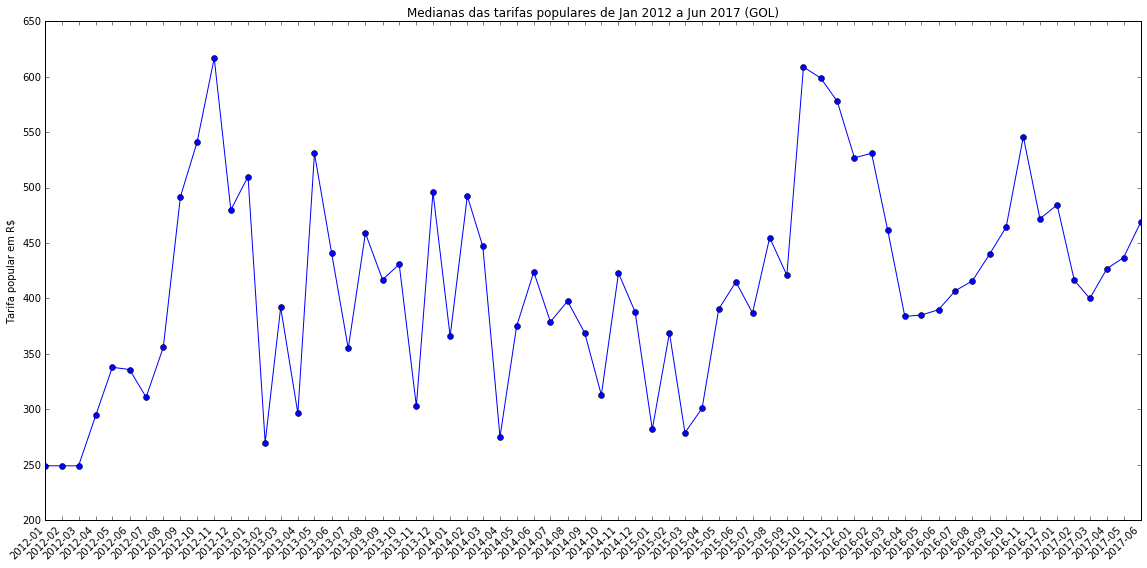

In [7]:
plt.rcParams["figure.figsize"] = (16, 8)
fig, ax = plt.subplots()
ax.set_xticks(pivoted.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title('Medianas das tarifas populares de Jan 2012 a Jun 2017 (GOL)')
ax.set_ylabel('Tarifa popular em R$')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()

plt.plot_date(x=pivoted.index, y=pivoted, ls='-')